- initial QC mode
- image and text reasoning

not yet
- combining domain, image, numeric interpretator result, also give it what are the function calls
- function calls
- code generation 
- validation QC mode, memory
- human in the loop
- multi channel/session/subject/dataset support
- real-time inspection and noise/artifact removal (question mark?)
- look again (loop until finish)

In [1]:
import os
import json
import base64
from typing import TypedDict, List, Dict, Any, Optional, Literal

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram

from dotenv import load_dotenv
import tiktoken

from pydantic import BaseModel
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser

from langgraph.graph import StateGraph, END
from openai import OpenAI


# ---------- 0. Token safeguards ----------

# Use GPT-4o tokenizer
enc = tiktoken.encoding_for_model("gpt-4o")


def prompt_to_text(prompt_obj):
    return prompt_obj.to_string() if hasattr(prompt_obj, "to_string") else str(prompt_obj)


def count_tokens(text: str) -> int:
    """Count tokens using GPT-4o tokenizer."""
    return len(enc.encode(text))


def enforce_token_limit(payload: str, max_tokens: int, context_name: str = "") -> str:
    """
    Ensures the payload stays under the token limit.
    Raises ValueError if it doesn't.
    """
    tok = count_tokens(payload)
    if tok > max_tokens:
        raise ValueError(
            f"[TOKEN LIMIT EXCEEDED in {context_name}] "
            f"Payload has {tok} tokens, exceeds limit of {max_tokens}. "
            f"Reduce numeric payload or increase reduction."
        )
    return payload


def reduce_numeric_results(numeric_results: Dict[str, Any]) -> Dict[str, Any]:
    """
    Compress large numeric analysis results (FFT, PSD, spectrogram)
    into small summary statistics that are safe to send to the LLM.
    """
    reduced: Dict[str, Any] = {}

    for key, value in numeric_results.items():
        # 1. Fourier spectrum
        if key == "fourier":
            freqs = value["freqs"]
            fft_vals = value["fft"]

            peaks = sorted(
                zip(freqs, fft_vals),
                key=lambda x: abs(x[1]),
                reverse=True,
            )[:10]

            reduced[key] = {
                "top_peaks": [
                    {"freq": float(f), "amp": float(a)} for f, a in peaks
                ],
                "max_amp": float(max(fft_vals)),
                "min_amp": float(min(fft_vals)),
                "n_samples": len(fft_vals),
            }

        # 2. PSD
        elif key == "psd":
            freqs = value["freqs"]
            psd_vals = value["psd"]

            peaks = sorted(
                zip(freqs, psd_vals),
                key=lambda x: abs(x[1]),
                reverse=True,
            )[:10]

            reduced[key] = {
                "top_peaks": [
                    {"freq": float(f), "power": float(p)} for f, p in peaks
                ],
                "max_power": float(max(psd_vals)),
                "mean_power": float(np.mean(psd_vals)),
                "n_freqs": len(psd_vals),
            }

        # 3. Spectrogram
        elif key == "spectrogram":
            Sxx = np.array(value["sxx"])
            reduced[key] = {
                "shape": list(Sxx.shape),
                "max_power": float(Sxx.max()),
                "mean_power": float(Sxx.mean()),
                "median_power": float(np.median(Sxx)),
                "dominant_freq_bin": int(np.argmax(Sxx.mean(axis=1))),
            }

        # 4. Simple scalar stats (variance, snr, etc. or metadata snapshot)
        else:
            reduced[key] = value

    reduced["_note"] = "Numeric arrays were reduced to summary statistics before LLM."
    return reduced


# ---------- 1. Pydantic models ----------

InspectionGoal = Literal["initial", "validation"]


class InspectionTask(BaseModel):
    name: str                   # e.g. "fourier", "psd", "variance"
    params: Dict[str, Any] = {} # task-specific parameters


class PlannerOutput(BaseModel):
    tasks: List[InspectionTask]
    rationale: str


class ExecutionOutput(BaseModel):
    numeric_results: Dict[str, Any]
    image_paths: List[str]
    metadata: Dict[str, Any]


class Interpretation(BaseModel):
    findings: Dict[str, Any]
    rationale: str


class FusionOutput(BaseModel):
    merged_findings: Dict[str, Any]


class InspectionSummary(BaseModel):
    issues_detected: List[str]
    metrics: Dict[str, Any]
    visual_findings: List[str]
    metadata_notes: List[str]
    final_summary: str


# ---------- 2. LangGraph state ----------

class InspectionState(TypedDict, total=False):
    # static inputs
    goal: str
    raw_data: List[float]
    metadata: Dict[str, Any]

    # pipeline intermediates
    planner_output: PlannerOutput
    execution_output: ExecutionOutput

    image_interp: Interpretation
    numeric_interp: Interpretation
    domain_interp: Interpretation

    fusion_output: FusionOutput
    inspection_summary: InspectionSummary


# ---------- 3. LLM setup ----------

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise RuntimeError("OPENAI_API_KEY not set. Add it to .env or export it before running.")

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0,
    api_key=openai_api_key,
)

vision_client = OpenAI(api_key=openai_api_key)


# ---------- 4. Planner node ----------

planner_parser = PydanticOutputParser(pydantic_object=PlannerOutput)

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a planner for a neural electrophysiology data inspection pipeline.
Your job is to decide WHAT analyses to run, not to run them.

You will be given:
- A goal ("initial" or "validation")
- Metadata about the recording

Return a list of high-level tasks to perform for inspection.
Do NOT write code. Just specify tasks like:
- "fourier"
- "psd"
- "variance"
- "snr"
- "channel_stats"
- "metadata_check"

Respond ONLY in the following JSON format:
{format_instructions}
""",
        ),
        (
            "user",
            "Goal: {goal}\nMetadata: {metadata}",
        ),
    ]
).partial(format_instructions=planner_parser.get_format_instructions())


def planner_node(state: InspectionState) -> Dict[str, Any]:
    goal = state["goal"]
    metadata = state.get("metadata", {})

    formatted = planner_prompt.format(
        goal=goal,
        metadata=json.dumps(metadata),
    )

    # Planner payload should be small, but still guard it lightly
    _ = enforce_token_limit(
        prompt_to_text(formatted),
        max_tokens=4000,
        context_name="planner",
    )

    result = llm.invoke(formatted)
    planner_output = planner_parser.parse(result.content)

    # IMPORTANT: only return updated keys, not full state
    return {"planner_output": planner_output}


# ---------- 5. Execution node (numeric + real plots) ----------

def execution_node(state: InspectionState) -> Dict[str, Any]:
    tasks = state["planner_output"].tasks
    raw = np.array(state["raw_data"], dtype=float)
    meta = state.get("metadata", {})
    fs = float(meta.get("sampling_rate", 30000.0))

    numeric_results: Dict[str, Any] = {}
    image_paths: List[str] = []

    # Ensure output dir exists
    os.makedirs("inspection_plots", exist_ok=True)

    for task in tasks:
        if task.name == "fourier":
            freqs = np.fft.rfftfreq(len(raw), 1.0 / fs)
            fft_vals = np.abs(np.fft.rfft(raw))
            numeric_results["fourier"] = {
                "freqs": freqs.tolist(),
                "fft": fft_vals.tolist(),
            }

            # ---- PLOT: Fourier magnitude ----
            plt.figure()
            plt.plot(freqs, fft_vals)
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("Magnitude")
            plt.title("Fourier Transform")
            fourier_path = os.path.join("inspection_plots", "fourier.png")
            plt.savefig(fourier_path, bbox_inches="tight")
            plt.close()
            image_paths.append(fourier_path)

        elif task.name == "psd":
            f, Pxx = welch(raw, fs=fs)
            numeric_results["psd"] = {
                "freqs": f.tolist(),
                "psd": Pxx.tolist(),
            }

            # ---- PLOT: PSD ----
            plt.figure()
            plt.semilogy(f, Pxx)
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("PSD")
            plt.title("Power Spectral Density")
            psd_path = os.path.join("inspection_plots", "psd.png")
            plt.savefig(psd_path, bbox_inches="tight")
            plt.close()
            image_paths.append(psd_path)

        elif task.name == "spectrogram":
            f, t, Sxx = spectrogram(raw, fs=fs)
            numeric_results["spectrogram"] = {
                "f": f.tolist(),
                "t": t.tolist(),
                "sxx": Sxx.tolist(),
            }

            # ---- PLOT: Spectrogram ----
            plt.figure()
            plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-12), shading="auto")
            plt.ylabel("Frequency (Hz)")
            plt.xlabel("Time (s)")
            plt.title("Spectrogram (dB)")
            spec_path = os.path.join("inspection_plots", "spectrogram.png")
            plt.savefig(spec_path, bbox_inches="tight")
            plt.close()
            image_paths.append(spec_path)

        elif task.name == "variance":
            numeric_results["variance"] = float(np.var(raw))

        elif task.name == "snr":
            signal_power = float(np.mean(raw ** 2))
            noise_power = float(np.var(raw - np.mean(raw)))
            snr = signal_power / (noise_power + 1e-12)
            numeric_results["snr"] = snr

        elif task.name == "channel_stats":
            numeric_results["channel_mean"] = float(np.mean(raw))
            numeric_results["channel_std"] = float(np.std(raw))

        elif task.name == "metadata_check":
            numeric_results["metadata_snapshot"] = meta

    exec_out = ExecutionOutput(
        numeric_results=numeric_results,
        image_paths=image_paths,
        metadata=meta,
    )
    return {"execution_output": exec_out}


# ---------- 6. Image interpreter node (images, using OpenAI native vision API) ----------

image_interp_parser = PydanticOutputParser(pydantic_object=Interpretation)


def image_interpreter_node(state: InspectionState) -> Dict[str, Any]:
    exec_out = state["execution_output"]
    image_paths = exec_out.image_paths

    if not image_paths:
        interp = Interpretation(
            findings={},
            rationale="No plots were generated to inspect."
        )
        return {"image_interp": interp}

    # ---- Build multimodal content for GPT-4o ----
    user_content: List[Dict[str, Any]] = [
        {
            "type": "text",
            "text": (
                "You are analyzing neural electrophysiology plots. "
                "For each image, look for artifacts such as:\n"
                "- 50/60 Hz line noise\n"
                "- broadband noise\n"
                "- clipping\n"
                "- baseline drift\n"
                "- motion artifact\n"
                "Respond ONLY with a JSON object following this schema:\n\n"
                f"{image_interp_parser.get_format_instructions()}"
            ),
        }
    ]

    for path in image_paths:
        with open(path, "rb") as f:
            b64 = base64.b64encode(f.read()).decode("utf-8")

        user_content.append(
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{b64}"
                }
            }
        )

    try:
        result = vision_client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": user_content,
                }
            ],
            max_tokens=1024,
        )

        # Depending on SDK version, content may be string or list
        msg_content = result.choices[0].message.content
        if isinstance(msg_content, list):
            # Join text parts if content blocks
            response_text = " ".join(
                block.get("text", "") if isinstance(block, dict) else str(block)
                for block in msg_content
            )
        else:
            response_text = msg_content

    except Exception as e:
        interp = Interpretation(
            findings={},
            rationale=f"Vision model error: {str(e)}",
        )
        return {"image_interp": interp}

    try:
        interp = image_interp_parser.parse(response_text)
    except Exception as e:
        interp = Interpretation(
            findings={},
            rationale=f"Failed to parse vision JSON: {response_text[:500]} ... Error: {str(e)}",
        )
        return {"image_interp": interp}

    return {"image_interp": interp}


# ---------- 7. Numeric interpreter node (with Safeguard 2) ----------

numeric_interp_parser = PydanticOutputParser(pydantic_object=Interpretation)

numeric_interp_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a NUMERIC interpreter for neural electrophysiology inspection.
You will be given numeric analysis results (FFT, PSD, variance, SNR, etc.), but only in
summary form (peaks, basic statistics). Raw arrays are not included.

Your job is to detect likely issues such as:
- 50/60 Hz line noise
- unusually high variance
- low SNR
- suspicious metadata values

Respond ONLY in this JSON format:
{format_instructions}
""",
        ),
        (
            "user",
            "Numeric results (JSON): {numeric_results}",
        ),
    ]
).partial(format_instructions=numeric_interp_parser.get_format_instructions())


def numeric_interpreter_node(state: InspectionState) -> Dict[str, Any]:
    exec_out = state["execution_output"]

    reduced = reduce_numeric_results(exec_out.numeric_results)
    payload = json.dumps(reduced)

    payload = enforce_token_limit(
        payload,
        max_tokens=6000,
        context_name="numeric_interpreter",
    )

    formatted = numeric_interp_prompt.format(
        numeric_results=payload
    )

    result = llm.invoke(formatted)
    interp = numeric_interp_parser.parse(result.content)
    return {"numeric_interp": interp}


# ---------- 8. Domain interpreter node ----------

domain_interp_parser = PydanticOutputParser(pydantic_object=Interpretation)

domain_interp_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a DOMAIN KNOWLEDGE interpreter for neural electrophysiology.
You will be given metadata (sampling rate, units, electrode type, etc.).
Your job is to:
- Check if parameters are reasonable for neural recordings
- Flag potential issues (e.g. too low sampling rate for spikes)
- Add any relevant domain-based warnings or confirmations.

Respond ONLY in this JSON format:
{format_instructions}
""",
        ),
        (
            "user",
            "Metadata: {metadata}",
        ),
    ]
).partial(format_instructions=domain_interp_parser.get_format_instructions())


def domain_interpreter_node(state: InspectionState) -> Dict[str, Any]:
    meta = state["execution_output"].metadata

    formatted = domain_interp_prompt.format(metadata=json.dumps(meta))

    _ = enforce_token_limit(
        prompt_to_text(formatted),
        max_tokens=4000,
        context_name="domain_interpreter",
    )

    result = llm.invoke(formatted)
    interp = domain_interp_parser.parse(result.content)
    return {"domain_interp": interp}


# ---------- 9. Fusion node ----------

def fusion_node(state: InspectionState) -> Dict[str, Any]:
    merged: Dict[str, Any] = {}

    for interp_key in ("image_interp", "numeric_interp", "domain_interp"):
        interp: Optional[Interpretation] = state.get(interp_key)  # type: ignore
        if interp:
            for k, v in interp.findings.items():
                merged[k] = v

    fusion = FusionOutput(merged_findings=merged)
    return {"fusion_output": fusion}


# ---------- 10. Summary node ----------

summary_parser = PydanticOutputParser(pydantic_object=InspectionSummary)

summary_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a summarizer for a neural data INSPECTION NODE.
You will be given:
- Merged findings from multiple interpreters
- Numeric results (already reduced)
- Individual interpreter rationales

Your job:
1. List concrete issues detected (noise, artifacts, metadata problems).
2. Summarize key metrics (SNR, variance, etc.).
3. Extract any important visual or numeric observations.
4. Add concise metadata-related notes.
5. Write a short final summary (2-4 sentences) suitable for a lab notebook.

Respond ONLY in this JSON format:
{format_instructions}
""",
        ),
        (
            "user",
            "Merged findings: {merged_findings}\nNumeric results: {numeric_results}\n"
            "Image rationale: {image_rationale}\nNumeric rationale: {numeric_rationale}\n"
            "Domain rationale: {domain_rationale}",
        ),
    ]
).partial(format_instructions=summary_parser.get_format_instructions())


def summary_node(state: InspectionState) -> Dict[str, Any]:
    fusion = state["fusion_output"]
    exec_out = state["execution_output"]
    img = state.get("image_interp")
    num = state.get("numeric_interp")
    dom = state.get("domain_interp")

    reduced_num = reduce_numeric_results(exec_out.numeric_results)

    formatted = summary_prompt.format(
        merged_findings=json.dumps(fusion.merged_findings),
        numeric_results=json.dumps(reduced_num),
        image_rationale=getattr(img, "rationale", "") if img else "",
        numeric_rationale=getattr(num, "rationale", "") if num else "",
        domain_rationale=getattr(dom, "rationale", "") if dom else "",
    )

    _ = enforce_token_limit(
        prompt_to_text(formatted),
        max_tokens=6000,
        context_name="summary",
    )

    result = llm.invoke(formatted)
    summary = summary_parser.parse(result.content)
    return {"inspection_summary": summary}


# ---------- 11. Build LangGraph ----------

def build_inspection_graph():
    graph = StateGraph(
        InspectionState,
        config={
            "static": ["goal", "raw_data", "metadata"]
        }
    )

    graph.add_node("planner", planner_node)
    graph.add_node("execute", execution_node)
    graph.add_node("image_interp", image_interpreter_node)
    graph.add_node("numeric_interp", numeric_interpreter_node)
    graph.add_node("domain_interp", domain_interpreter_node)
    graph.add_node("fusion", fusion_node)
    graph.add_node("summary", summary_node)

    graph.set_entry_point("planner")
    graph.add_edge("planner", "execute")
    graph.add_edge("execute", "image_interp")
    graph.add_edge("execute", "numeric_interp")
    graph.add_edge("execute", "domain_interp")
    graph.add_edge("image_interp", "fusion")
    graph.add_edge("numeric_interp", "fusion")
    graph.add_edge("domain_interp", "fusion")
    graph.add_edge("fusion", "summary")
    graph.add_edge("summary", END)

    return graph.compile()


In [2]:
# ---------- 12. Example usage ----------

if __name__ == "__main__":
    app = build_inspection_graph()

    # Fake toy data: sine wave + 60 Hz noise
    fs = 30000.0
    t = np.arange(0, 1.0, 1.0 / fs)
    raw = 50 * np.sin(2 * np.pi * 100 * t) + 5 * np.sin(2 * np.pi * 60 * t)

    initial_state: InspectionState = {
        "goal": "initial",
        "raw_data": raw.tolist(),
        "metadata": {
            "sampling_rate": fs,
            "units": "uV",
            "electrode_type": "cuff",
        },
    }

    def safe_serialize(obj):
        if hasattr(obj, "model_dump"):
            return safe_serialize(obj.model_dump())
        if isinstance(obj, np.ndarray):
            return f"np.ndarray(shape={obj.shape})"
        if isinstance(obj, list):
            if len(obj) > 50:   # truncate long lists
                return f"[...{len(obj)} items...]"
            return [safe_serialize(v) for v in obj]
        if isinstance(obj, dict):
            return {k: safe_serialize(v) for k, v in obj.items()}
        return obj

    print("=== DEBUG STREAM OF PIPELINE ===")

    for event in app.stream(initial_state):
        print("\n--- NODE:", event["node"] if "node" in event else "UNKNOWN", "---")
        print(json.dumps(safe_serialize(event), indent=2))

    print("\n=== FINAL RESULT ===")
    final_state = app.invoke(initial_state)
    print(final_state["inspection_summary"])


=== DEBUG STREAM OF PIPELINE ===

--- NODE: UNKNOWN ---
{
  "planner": {
    "planner_output": {
      "tasks": [
        {
          "name": "metadata_check",
          "params": {}
        },
        {
          "name": "channel_stats",
          "params": {}
        },
        {
          "name": "variance",
          "params": {}
        },
        {
          "name": "psd",
          "params": {}
        },
        {
          "name": "fourier",
          "params": {}
        },
        {
          "name": "snr",
          "params": {}
        }
      ],
      "rationale": "For an initial inspection, it is important to verify the metadata, assess the basic statistics of the channels, and evaluate the signal quality and characteristics. This includes checking the variance, power spectral density (PSD), and performing a Fourier analysis to understand the frequency components. Signal-to-noise ratio (SNR) is also crucial to assess the quality of the recorded signals."
    }
  }
}

---

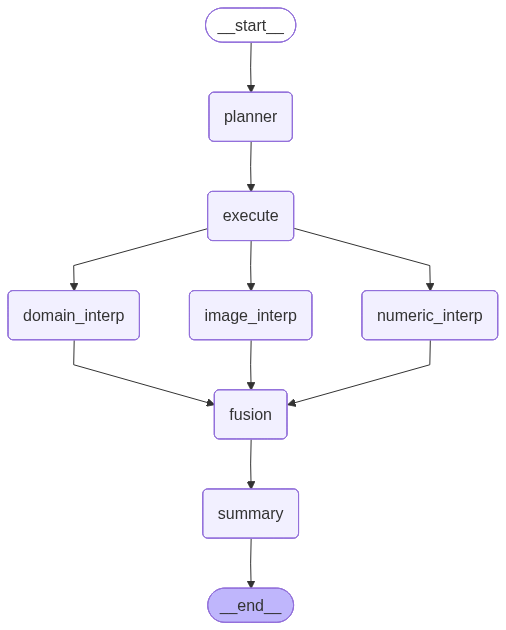

In [3]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Failed to display graph: {str(e)}")